# Intro
It always starts with what seems to be a normal day. You try to pay something with you credit card and it is declined. Huh, that is weird, but you don’t think too much about it. You check your bank later today just to see what’s up. You are locked out. Panic starts to ensue. You call your bank see what is going on. The person on the phone asks if you made a purchase for 300 Xboxes to be sent to Indonesia. You tell them no and are able to get account unlocked and the fraudulent order canceled. 

In 2018 alone, more than 24.2 billion dollars were lost worldwide due to fraudulent activity and the US is the most prone to it, with 38.6% of cases residing from there.[xx]  The problem is only continuing to grow, so how can stop it, or at least detect it? With this Capstone project, I am going to be working with a dataset about fraudulent activity. The dataset comes from Kaggle and is a dataset of fraudulent and non-fraudulent transactions that occurred by European Cardholders from two days in September 2013.[xx]  Our goal is to explore the dataset, create a few models, and see if we can predict fraudulent transactions. 

We will do this by creating a number of different model types, feeding in different input data (the original data, an under sampled version, and an oversampled version), and hyper tuning the parameters to see what gives us the best results.

# Imports

In [47]:
# The basics
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
import time

# The visulaizations tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# The models, optimizers, and other related libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier 
from sklearn.metrics import precision_score, precision_recall_curve, confusion_matrix, f1_score, average_precision_score, recall_score, classification_report
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import joblib 
import pickle

# The neural netowkr imports
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
# Just so we can see a bit more with the columns
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Data Loading and EDA

In [3]:
df = pd.read_csv('/Users/micgoldm/Downloads/creditcard.csv')

In [4]:
df.shape

(284807, 31)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
missing = (df.isnull().sum()*100/len(df)).to_frame(name = '% null').T
pd.concat([df.describe(), missing])

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000
% null,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000


No missing data. We will visualize the columns to see if there is a major difference between fraud cases and non-fraud cases. One thing that we do notice is that the variables appear to be scaled, except for Time and Amount. We will rescale them as well.

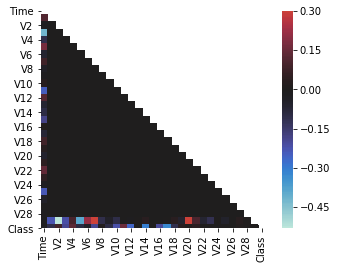

In [7]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, center=0, vmax=.3, square=True)

The variables in the correlation map don't appear to be related (at least in a linear fashion), so it wouldn't make sense to combine variables. 

Note: If we wanted to be extremely thorough, we could graph a scatter plot of each of these varaibles against each other to see if there were truly a nonlinear relationship, but because the dataset said it was put through a PCA, they wouldn't.

Since the columns are not correlated with each other, we shouldn't combine columns together to get additional explaning power/deal with multicollinearity. That being said, we can still look at correlation between the variables and the target variable, `class`.

In [8]:
# Lets see the most correlated (postively or negatively) variables to our target
df.corr().reindex(df.corr()['Class'].abs().sort_values(ascending=False).index)['Class'].drop('Class')

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V11       0.154876
V4        0.133447
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V2        0.091289
V6       -0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time     -0.012323
V28       0.009536
V24      -0.007221
Amount    0.005632
V13      -0.004570
V26       0.004455
V15      -0.004223
V25       0.003308
V23      -0.002685
V22       0.000805
Name: Class, dtype: float64

Looks like the PCA columns are only weakly correlated `.4 > abs(corr of col) >= .2`. There are a number of columns that don't appear to have much explanitory power. We might be able to drop  columns or run the columns through PCA or TSNE again to get a more efficient model. 

Lets see the ratio of fraudulent to non-fraudulent transactions

In [9]:
print("Number of fraudulent transactions: {} ({}%)".format(sum(df['Class']), sum(df['Class'])*100/len(df['Class'])))


Number of fraudulent transactions: 492 (0.1727485630620034%)


A very small fraction of these reports are fraudulent (which is good news for the world). This means that our dataset is extremely imbalanced, so we might have to address this in our process

Since the data for all other columns are somewhat scaled, we should do the same with time and amount. We will use RobustScalar.

In [10]:
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

df = df.drop(['Amount','Time'],axis=1)

Lets visualize some of the columns that had higher correlation to the class, separating out by class type (espeically V17, V14, V12, and V10)

In [11]:
full_x = df.drop('Class',axis=1)
full_y = df['Class']

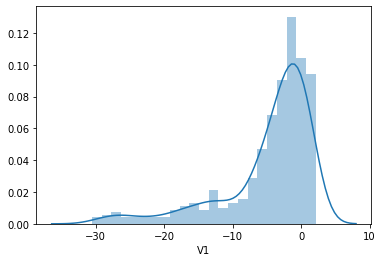

In [12]:
sns.distplot(df['V1'][df.Class ==1])

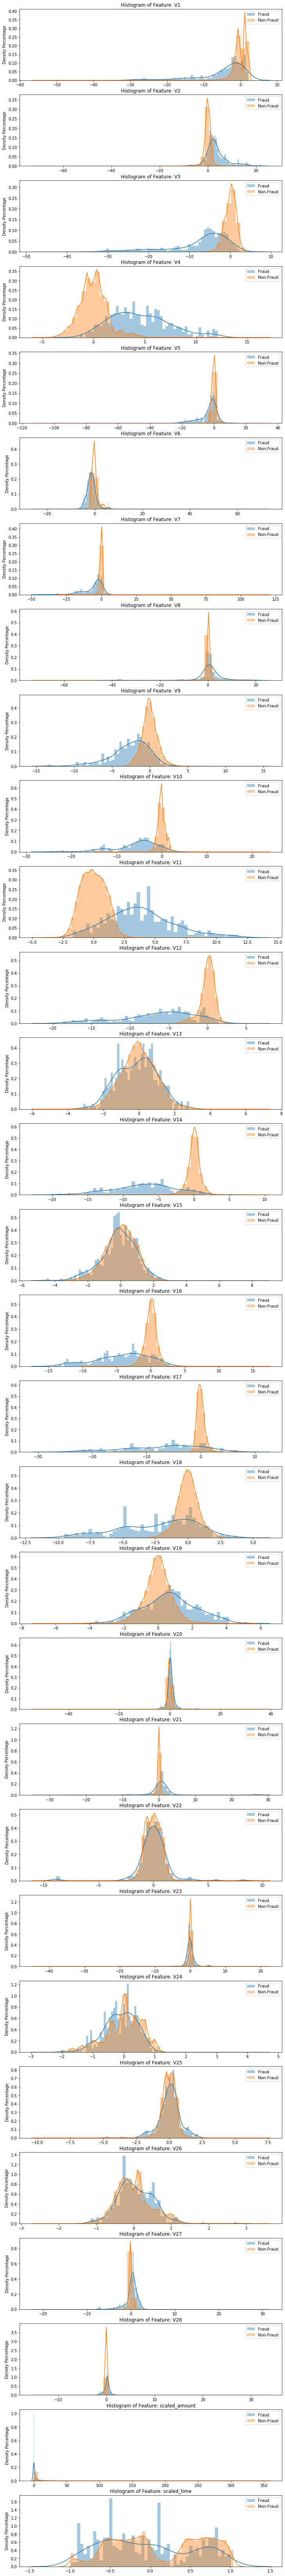

In [13]:
plt.figure(figsize=(12,30*4))
gs = gridspec.GridSpec(30, 1)
for i, cn in enumerate(full_x):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50, label = 'Fraud')
    sns.distplot(df[cn][df.Class == 0], bins=50, label = 'Non-Fraud')
    ax.set_xlabel('')
    ax.set_ylabel('Density Percentage')
    ax.legend()
#     ax.legend((line1, line2))
    ax.set_title('Histogram of Feature: ' + str(cn))
plt.show()

Lets see how many outliers there are

In [14]:
full_x[(np.abs(stats.zscore(full_x)) < 3).all(axis=1)]


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284800,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,0.523316,0.559047,-0.834660,0.626211,-0.541494,0.225361,-0.605252,-0.163049,0.561695,-0.256922,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,-0.269964,1.034928
284801,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,0.644837,0.190916,-0.546329,-0.731707,-0.808036,0.599628,0.070441,0.373110,0.128904,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975


If we remove all outliers, then we will be dropping about 90% of our fraudulent cases. Since we do not have information on which column outliers we should drop, I will keep them all. If we had information on all the columns, then I would be more precise and take out more outliers.

# Full Data - Dimensionality Reduction

### Exploring PCA

In [15]:
# for i in range(30):
pca = PCA(n_components=30)
pca_x = pca.fit_transform(full_x)

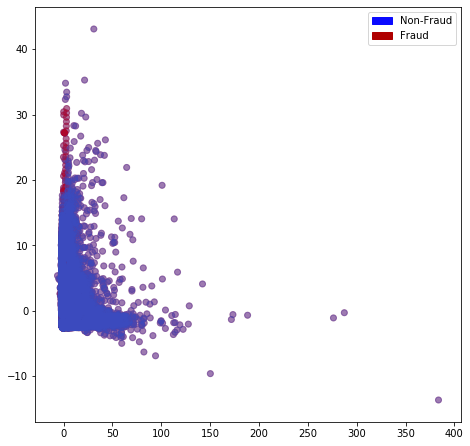

In [16]:
non_fraud = mpatches.Patch(color='#0A0AFF', label='Non-Fraud')
fraud = mpatches.Patch(color='#AF0000', label='Fraud')

plt.figure(figsize=(90,90))
gs = gridspec.GridSpec(10, 10)
ax = plt.subplot(gs[0])

ax.scatter(pca_x[:,0], pca_x[:,1], c=(full_y == 0), cmap='coolwarm', label='Non-Fraud',alpha=.4)
ax.scatter(pca_x[:,0], pca_x[:,1], c=(full_y == 1), cmap='coolwarm', label='Fraud', alpha = .4)
ax.legend(handles=[non_fraud,fraud])
plt.show()

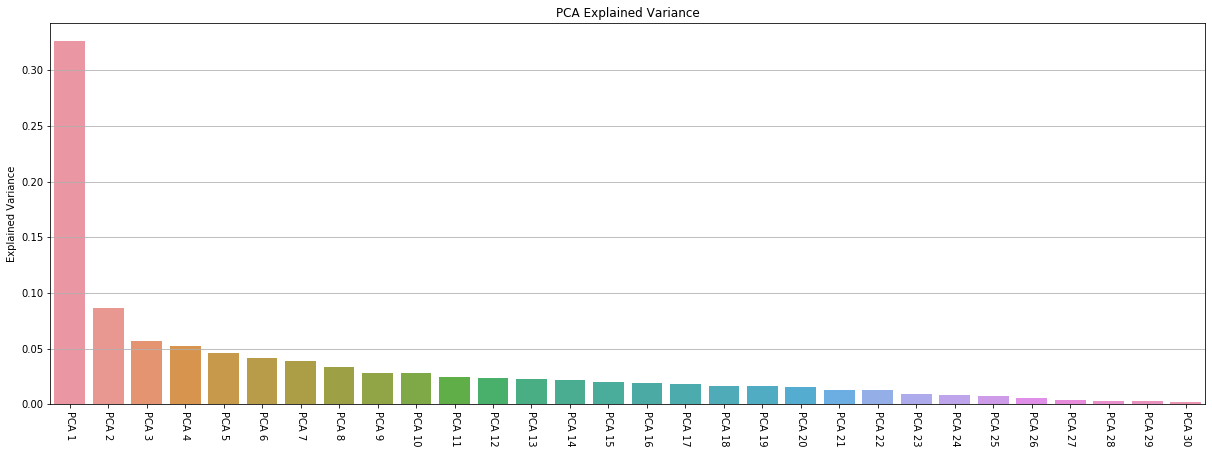

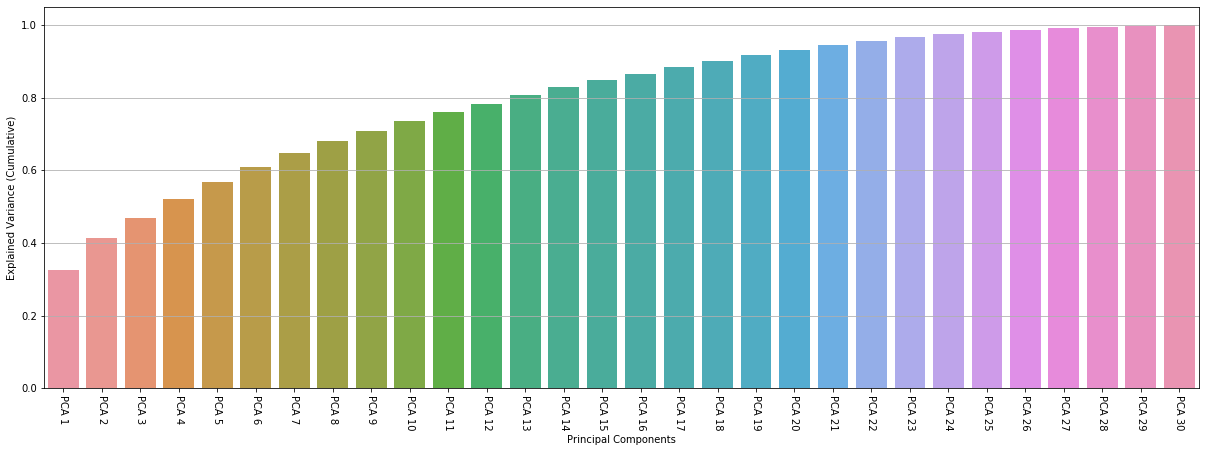

In [17]:
pca_lst= []
for i in range(30):
    pca_lst.append("PCA {}".format(str(i+1)))

plt.figure(figsize=(120,150))
gs = gridspec.GridSpec(18, 5)
ax = plt.subplot(gs[0])
sns.barplot(data = df,
            x=pca_lst,
            y = pca.explained_variance_ratio_
           )
plt.tick_params(axis='x', rotation = -90)
plt.grid(b=True, axis = 'y')
ax.set_title('PCA Explained Variance')
ax.set_ylabel('Explained Variance')

plt.show()

plt.figure(figsize=(120,150))
ax = plt.subplot(gs[1])
sns.barplot(data = df,
            x=pca_lst,
            y = np.cumsum(pca.explained_variance_ratio_)
           )

plt.grid(b=True, axis = 'y')
plt.tick_params(axis='x', rotation = -90)
ax.set_ylabel('Explained Variance (Cumulative)')
ax.set_xlabel('Principal Components')

plt.show()

The scree plots aren't the best since the first PCA only explains around 30% of the varaince. Because of this, we will likely have to use percentage of varaince if we want to use a model with reduced features. We won't reduce our features just yet, but we will potentially explore reducing the featuers after we sample the dataset.

# Split the Data

In [18]:
train_x, test_x, train_y, test_y = train_test_split(full_x, full_y, random_state = 68, test_size = .3)

## Naïve Benchmark - Logistic Regression

This will be our simples model. It will not use any cross validation, no parameter tuning, nothing fancy. Just a simple logistic regression

In [19]:
benchmark_model = LogisticRegression(random_state=68)

In [20]:
benchmark_pipeline = make_pipeline(benchmark_model)
benchmark_fitted = benchmark_pipeline.fit(train_x, train_y)
benchmark_preds = benchmark_fitted.predict(test_x)

/Users/micgoldm/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lets see which features had the biggest impact in determining if the transaction was fraudulent or not.

This would be more useful if the column names were more descriptive.

In [21]:
benmarch_features = {}
for i in range(len(full_x.columns)):
    benmarch_features[full_x.columns[i]] = benchmark_model.coef_[0][i]
sorted(benmarch_features.items(), key=lambda x: abs(x[1]), reverse=True)

[('V10', -0.6941980145885993),
 ('V4', 0.6479608621138007),
 ('V27', -0.6450146836209429),
 ('V22', 0.5997655342641028),
 ('V14', -0.5125498848630312),
 ('V20', -0.35156346453454906),
 ('V21', 0.3492136578170192),
 ('V13', -0.307017888095559),
 ('scaled_time', -0.24340776804467604),
 ('V9', -0.23458361049952994),
 ('V28', -0.21861023461627313),
 ('V16', -0.1918074059784625),
 ('V26', 0.17810916164901047),
 ('V8', -0.17338679749287353),
 ('V25', -0.14157150936128712),
 ('V6', -0.13536107250659388),
 ('V5', 0.1260028501311319),
 ('V19', 0.11515461024761614),
 ('V15', -0.10195778769613686),
 ('V24', 0.08195517060827867),
 ('V23', -0.06582646083084648),
 ('V7', -0.05652362226421921),
 ('scaled_amount', 0.05427291369688963),
 ('V18', -0.0533374674713205),
 ('V1', 0.05284591783824484),
 ('V12', 0.051122554323641906),
 ('V2', 0.03407264445364037),
 ('V3', -0.0275465527743242),
 ('V11', -0.025972692920729942),
 ('V17', -0.0026705353411919817)]

We will see if these features are the most informative in our other models

# Evaluation Metrics

In [43]:
def score_model(test_y, pred_y, fitted_model, model_name = None, return_data = False):
    '''
    INPUT:
    pred_x: Array - an array of predicted output of the model
    test_y: Array - an array of results that the model was attempting to predict
    fitted_model: Model - used to draw the AUPR curve
    model_name: String - model's name
    return_data: Boolean - a boolean that determines whether to return the data
    nn_model: Boolean - a boolean to determine what function the plotting of the AUPRC curve should use. If it is a non-sequential model, then use decision function. If not, then use predict_proba. 
    
    OUTPUT:
    if return_data:
        Returns the precision, recall, f1 score, confusion matrix, and average-precision-recall score
    else:
        None
    
    PURPOSE:
    This funciton will score the model on its sensitivity, recall, precision, f1 score, average-precision. It will also graph a AUPRC curve so we are more easily able to compare models with each other.
    '''
    
    if model_name != None:
        print("Scoring Results for: {}".format(str(model_name)))
    else:
        print("Scoring Results:")
    try:
        report = classification_report(test_y, pred_y, output_dict=True)['1']
        conf_mat = confusion_matrix(test_y, pred_y)
    except: 
        try:
            # If the model predictions is continuous, lets just round it to the proper class
            report = classification_report(test_y, pred_y.round(), output_dict=True)['1']
        except:
            # For some reason, the model sometimes reports a '1.0', instead of '1'
            report = classification_report(test_y, pred_y.round(), output_dict=True)['1.0']
        conf_mat = confusion_matrix(test_y, pred_y.round())
    avg_pre = round(average_precision_score(test_y, pred_y),3)
    
    # Print out the results of the model
    print("-"*30)
    print("Precision: {}".format(round(report['precision'],3)))
    print("Recall: {}".format(round(report['recall'],3)))
    print("F1 Score: {}".format(round(report['f1-score'],3)))
    print("Confusion Matrix: \n{}".format(conf_mat))
    print("AUPRC Score: {}".format(avg_pre))
    
    # Plot out the AUPRC
    fig = plt.figure(figsize=(12,6))
    # These try excepts are to use the function that best visualizes the precision recall curve. For some models
    # it uses the funciton 'predict_proba', while others use 'decision_function'. 
    try:
        precision, recall, _ = precision_recall_curve(test_y, fitted_model.decision_function(test_x))
    except:
        try:
            precision, recall, _ = precision_recall_curve(test_y, fitted_model.predict_proba(test_x.values)[:, 1])
        except:
            # As a catch-all, if neither work, use the predicted results (boxed shaped plot, only 3 data points 
            # showing the end of the precision-recall curve)
            precision, recall, _ = precision_recall_curve(test_y, pred_y)
        
    # Format the chart
    plt.step(recall, precision, color='#004a93', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='#48a6ff')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    if model_name != None:
        plt.title('{} Model - Precision-Recall curve'.format(model_name), fontsize=16)
    else:
        plt.title('Precision-Recall curve', fontsize=16)
        
    # Unclear if this is necessary, but if we want to store the results, lets return the output
    # so it is easier to do so
    if return_data:
        return report['precision'], report['recall'], report['f1-score'], conf_mat, avg_pre
    else:
        return None

Scoring Results for: Benchmark Model - Logistic Regression
------------------------------
Precision: 0.907
Recall: 0.569
F1 Score: 0.7
Confusion Matrix: 
[[85298     8]
 [   59    78]]
AUPRC Score: 0.517


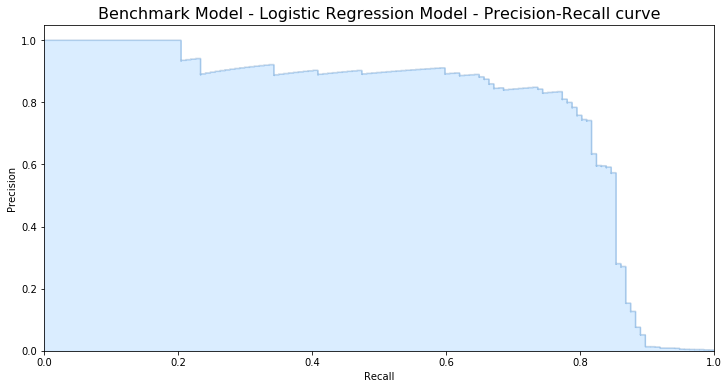

In [44]:
score_model(test_y, benchmark_preds, benchmark_fitted, 'Benchmark Model - Logistic Regression')

# Creation of models

We want to create a number of classification models:
 - SGDClassifier
     - This uses similar penalty for Elastic Net, so we can try to capture the ratio of l1 and l2 penality when doing our regression
 - Random Forest
     - A tree based model that has somewhat good predicting power without much risk of overfitting
 - XGBoost
     - A very powerful tree based model that predicts on the residual of its previous predictions. It has won multiple competitions with its predictive abilities.
 - A Simple Neural Network
     - A baseline neural network to see how it will learn in comparison to our other models
 - A Deeper Neural Network
     - Another neural network with more layers and a dropouts to see how it will compare
 
We are also going to provide a list of parameters for each of these models that we will tune to see if we can improve our results. We will then fit and tune our models on the weighted data and the undersampled data. We will also be using crossvalidation and training to see which CV works best. We are going to make the models as functions in order to make our training process easier later on. The inputs of the functions will be the parameters that we will optimize on

Because the cost of not-detecting fraud is so high, we will train our models on recall. Although flagging transactions as suspicious that are ordinary is also not a good thing, the cost is less than if fraud unnoticed.

# Model Creations

In [24]:
## Lets see what socring metrics we want to use during our cross validation
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

We will use both average precision and recall and see if there are any differences

#### SGDClassifier 

In [25]:
def SD_func(alpha, l1_ratio, max_iter, cv=5, n_jobs=-1, train_x = train_x, train_y = train_y):
    val = cross_val_score(SGDClassifier(alpha=alpha, 
                                     l1_ratio=l1_ratio, 
                                     max_iter = max_iter,
                                     random_state = 68),
                          train_x, 
                          train_y, 
                          cv=cv, 
                          n_jobs=n_jobs, 
                          scoring = 'average_precision').mean()
    return val

#### Random Forest

In [26]:
def RF_func(n_estimators, max_depth, min_samples_split, cv=5, n_jobs=-1, train_x = train_x, train_y = train_y):
#     print(int(n_estimators), int(max_depth), int(min_samples_split))
    val = cross_val_score(RandomForestClassifier(n_estimators = int(n_estimators),
                                               max_depth = int(max_depth),
                                               min_samples_split = int(min_samples_split),
                                               random_state = 68),
                         train_x, 
                         train_y, 
                         cv=5, 
                         n_jobs=n_jobs, 
                         scoring = 'average_precision').mean()
    return val

#### XGBoost

In [27]:
def XG_func(n_estimators, learning_rate, max_depth, min_child_weight, gamma, colsample_bytree, cv = 5, train_x = train_x, train_y = train_y):
    val = cross_val_score(XGBClassifier(n_estimators=int(n_estimators),
                                        learning_rate = learning_rate,
                                        max_depth=int(max_depth), 
                                        min_child_weight = int(min_child_weight),
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree
                                        ),
                          train_x, 
                          train_y, 
                          cv = 5, 
                          n_jobs = -1, 
                          scoring = 'average_precision').mean()
    return val

#### Sequential Neural Network - K.I.S.S.

In [28]:
tf.compat.v1.get_default_graph
input_dim = train_x.shape[1]

ks_model = Sequential()
ks_model.add(layers.Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim)) 
ks_model.add(layers.Dense(input_dim, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
ks_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['binary_accuracy'])

#### Sequential Neural Network - Dense and Dropouts

In [29]:
input_dim = train_x.shape[1]

nn_model = Sequential()
nn_model.add(layers.Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim)) 
nn_model.add(Dropout(0.1))
nn_model.add(layers.Dense(25, kernel_initializer='uniform', activation=tf.nn.relu))
nn_model.add(Dropout(0.1))
nn_model.add(layers.Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
nn_model.add(layers.Dense(input_dim, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
nn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['binary_accuracy'])

# Dealing with Data Imbalance

We shall deal with the data imbalance in 3 different ways. The first way is to not deal with it. We will see how the models predict after tuning the models on the regular dataset. The second way is to undersample the data so the instances of fraud match the instances of non-fraud (50% cases of fraud, 50% cases of non-fraud). The third way to deal with the balance is to oversample the smaller cases of fraud. 

Since we are not balancing the dataset, we want to use recall as our scoring method to make sure that we don't get 'good models' by just predicting everything is non-fraud

### Imbalanced - No change to dataset
We are just going to train and tune our models on the orginal dataset

#### SDGclassifier

In [30]:
sdg_BO = BayesianOptimization(SD_func, {"alpha":(1e-4,10), "l1_ratio":(0,1), "max_iter":(50,2000)})
sdg_BO.maximize(n_iter=30)    

|   iter    |  target   |   alpha   | l1_ratio  | max_iter  |
-------------------------------------------------------------
|  1        |  0.7186   |  6.301    |  0.1279   |  1.796e+0 |
|  2        |  0.7359   |  8.334    |  0.8879   |  1.183e+0 |
|  3        |  0.6928   |  1.245    |  0.4861   |  501.6    |
|  4        |  0.7278   |  7.472    |  0.3786   |  852.6    |
|  5        |  0.7316   |  7.732    |  0.8662   |  1.612e+0 |
|  6        |  0.7452   |  0.01974  |  0.09336  |  1.342e+0 |
|  7        |  0.7471   |  0.001341 |  0.04744  |  1.395e+0 |
|  8        |  0.7387   |  0.07754  |  0.9768   |  1.407e+0 |
|  9        |  0.7311   |  0.1399   |  0.4894   |  50.34    |
|  10       |  0.7429   |  8.943    |  0.1119   |  1.999e+0 |
|  11       |  0.7461   |  9.909    |  0.01749  |  1.356e+0 |
|  12       |  0.739    |  0.09756  |  0.4286   |  2e+03    |
|  13       |  0.7461   |  9.887    |  0.02264  |  1.347e+0 |
|  14       |  0.7465   |  9.977    |  0.01792  |  1.333e+0 |
|  15   

In [31]:
max_score = 0
sd_best_params = {"alpha":0, "l1_ratio":0, "max_iter":0}
for i, res in enumerate(sdg_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        sd_best_params['alpha'] = res['params']['alpha']
        sd_best_params['l1_ratio'] = res['params']['l1_ratio']
        sd_best_params['max_iter'] = res['params']['max_iter']
print(max_score)
print(sd_best_params)

0.7471453027780716
{'alpha': 0.0013409086004707764, 'l1_ratio': 0.04744022233740153, 'max_iter': 1395.3494769687609}


In [32]:
sd_model = SGDClassifier(alpha=sd_best_params['alpha'],
                      l1_ratio=sd_best_params['l1_ratio'], 
                      max_iter=sd_best_params['max_iter'],
                      random_state = 68)

In [33]:
sd_pipeline = make_pipeline(sd_model)
sd_fitted = sd_pipeline.fit(train_x, train_y,)
sd_preds = sd_fitted.predict(test_x)

Scoring Results for: SDG Classifier
------------------------------
Precision: 0.875
Recall: 0.46
F1 Score: 0.603
Confusion Matrix: 
[[85297     9]
 [   74    63]]
AUPRC Score: 0.403


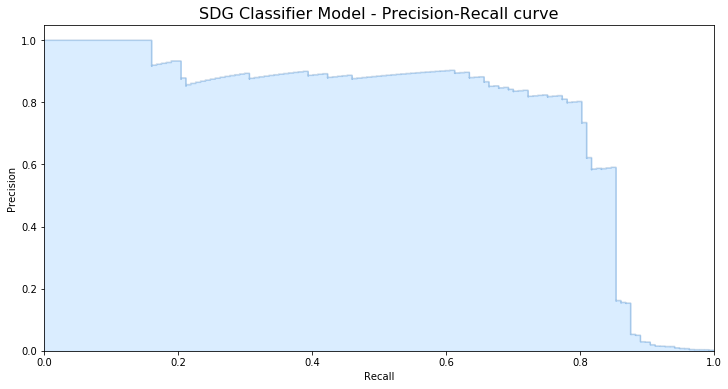

In [45]:
score_model(test_y, sd_preds, sd_fitted, 'SDG Classifier')

In [35]:
joblib.dump(sd_fitted, 'capstone_models/imbalanced/sdgclassifier_average_precision.pkl') 
sd_fitted = joblib.load('capstone_models/imbalanced/sdgclassifier_average_precision.pkl')  


In [57]:
start = time.time()

#### Random Forest

In [58]:
rforest_BO = BayesianOptimization(RF_func, 
                                  {'n_estimators':(200,400), 
                                   'max_depth':(10,500),
                                   'min_samples_split':(2,10)})

rforest_BO.maximize(n_iter=30)  

# rf_BO = BayesianOptimization(rf_func, {'n_estimators': (200,400), 'max_depth': (10,500)})
# rf_BO.explore({"n_estimators":np.linspace(200,400,30), 'max_depth':np.linspace(250,450,30)})

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8478   |  290.0    |  8.811    |  396.7    |
|  2        |  0.8495   |  391.7    |  6.819    |  338.3    |
|  3        |  0.8504   |  448.0    |  5.826    |  299.2    |
|  4        |  0.8521   |  141.3    |  3.125    |  217.4    |
|  5        |  0.8474   |  366.2    |  9.743    |  297.9    |
|  6        |  0.8389   |  10.08    |  5.173    |  200.5    |
|  7        |  0.8534   |  17.14    |  2.15     |  397.0    |
|  8        |  0.8496   |  499.0    |  2.409    |  200.4    |
|  9        |  0.8529   |  497.3    |  2.149    |  398.9    |
|  10       |  0.852    |  156.1    |  2.009    |  333.6    |
|  11       |  0.8496   |  307.1    |  2.001    |  200.9    |
|  12       |  0.8481   |  79.35    |  9.896    |  398.3    |
|  13       |  0.8518   |  498.4    |  2.016    |  322.8    |
|  14       |  0.8529   |  108.6    |  2.013    |  398.4    |
|  15   

In [59]:
max_score = 0
rf_best_params = {"n_estimators":0, "max_depth":0, "min_samples_split":0}
for i, res in enumerate(rforest_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        rf_best_params['n_estimators'] = res['params']['n_estimators']
        rf_best_params['max_depth'] = res['params']['max_depth']
        rf_best_params['min_samples_split'] = res['params']['min_samples_split']
print(max_score)
print(rf_best_params)

0.8549297697210385
{'n_estimators': 399.097508938181, 'max_depth': 23.637657114600152, 'min_samples_split': 2.0538942257041253}


In [60]:
rf_model = RandomForestClassifier(n_estimators = int(rf_best_params['n_estimators']),
                                  max_depth = int(rf_best_params['max_depth']),
                                  min_samples_split = int(rf_best_params['min_samples_split']),
                                  random_state = 68)

In [61]:
rf_pipeline = make_pipeline(rf_model)
rf_fitted = rf_pipeline.fit(train_x, train_y,)
rf_preds = rf_fitted.predict(test_x)

Scoring Results for: Random Forest
------------------------------
Precision: 0.937
Recall: 0.759
F1 Score: 0.839
Confusion Matrix: 
[[85299     7]
 [   33   104]]
AUPRC Score: 0.712


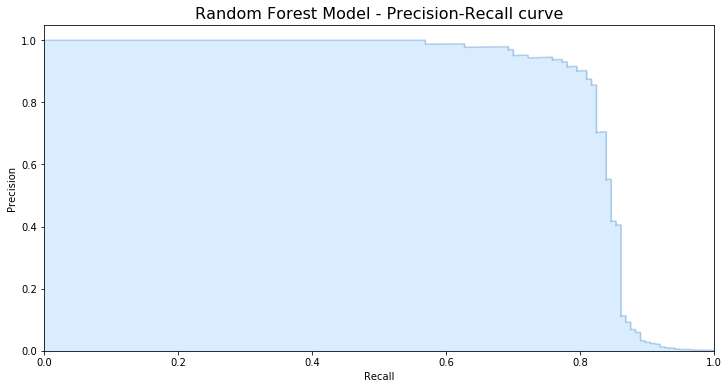

In [62]:
score_model(test_y, rf_preds, rf_fitted, 'Random Forest')

In [63]:
joblib.dump(rf_fitted, 'capstone_models/imbalanced/randomforest_average_precision.pkl') 
rf_fitted = joblib.load('capstone_models/imbalanced/randomforest_average_precision.pkl')

In [64]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

05:51:31.17


This took a long time to train... Have to leave the computer on overnight to train the rest

#### XGBoost

In [65]:
xgboost_BO = BayesianOptimization(XG_func, 
                                 {'n_estimators': (100, 1000),
                                     'learning_rate': (.001, .5),
                                     'max_depth': (1,20),
                                     "gamma": (0,1),
                                     'min_child_weight': (1,10),
                                     "colsample_bytree" : (0.1, 0.9)
                                 })

xgboost_BO.maximize(n_iter=30)  

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
|  1        |  0.858    |  0.7035   |  0.6471   |  0.1596   |  7.046    |  2.318    |  690.2    |
|  2        |  0.855    |  0.4579   |  0.8183   |  0.4038   |  13.43    |  5.588    |  166.3    |
|  3        |  0.8491   |  0.1525   |  0.08585  |  0.02423  |  18.46    |  1.643    |  400.4    |
|  4        |  0.8494   |  0.5982   |  0.604    |  0.3127   |  1.572    |  1.325    |  727.8    |
|  5        |  0.8571   |  0.2841   |  0.2414   |  0.03036  |  6.247    |  1.719    |  794.9    |
|  6        |  0.8518   |  0.1097   |  0.005407 |  0.02205  |  19.85    |  9.124    |  998.2    |
|  7        |  0.8491   |  0.2639   |  0.8298   |  0.4431   |  19.95    |  2.106    |  100.1    |
|  8        |  0.8575   |  0.6484   |  0.2821   |  0.2252   |  19.94    |  9.8      |  753.5    |
|  9        |  0.849

In [165]:
max_score = 0
xg_best_params = {"n_estimators":0, 
                  "learning_rate":0, 
                  "max_depth":0,
                  "min_child_weight":0,
                  "gamma":0,
                  "colsample_bytree":0,
                 }
for i, res in enumerate(xgboost_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        xg_best_params['n_estimators'] = res['params']['n_estimators']
        xg_best_params['learning_rate'] = res['params']['learning_rate']
        xg_best_params['max_depth'] = res['params']['max_depth']
        xg_best_params['min_child_weight'] = res['params']['min_child_weight']
        xg_best_params['gamma'] = res['params']['gamma']
        xg_best_params['colsample_bytree'] = res['params']['colsample_bytree']
print(max_score)
print(xg_best_params)

0.861334298470444
{'n_estimators': 176.58282846165528, 'learning_rate': 0.2366998237551639, 'max_depth': 19.942181917244856, 'min_child_weight': 1.594288904802284, 'gamma': 0.032935961979789985, 'colsample_bytree': 0.8336101079754762}


In [166]:
xg_model = XGBClassifier(n_estimators=int(xg_best_params['n_estimators']),
                         learning_rate = xg_best_params['learning_rate'],
                         max_depth=int(xg_best_params['max_depth']), 
                         min_child_weight = int(xg_best_params['min_child_weight']),
                         gamma = xg_best_params['gamma'],
                         colsample_bytree = xg_best_params['colsample_bytree']
                        )

In [167]:
xg_pipeline = make_pipeline(xg_model)
xg_fitted = xg_pipeline.fit(train_x, train_y,)
xg_preds = xg_fitted.predict(test_x)

Scoring Results for: XGBoost
------------------------------
Precision: 0.938
Recall: 0.774
F1 Score: 0.848
Confusion Matrix: 
[[85299     7]
 [   31   106]]
AUPRC Score: 0.726


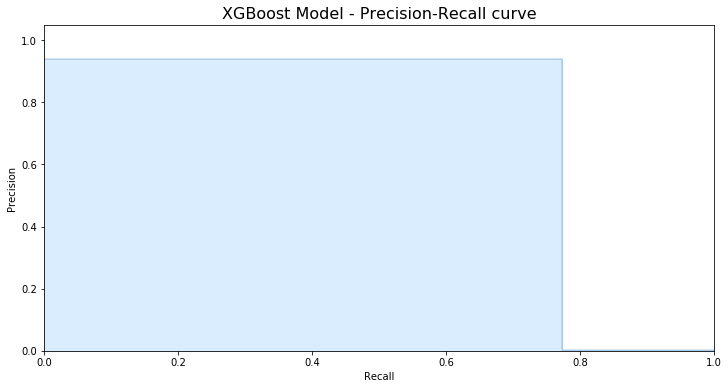

In [168]:
score_model(test_y, xg_preds, xg_fitted, 'XGBoost')

In [70]:
joblib.dump(xg_fitted, "capstone_models/imbalanced/xgboost_average_precision.pkl") 
xg_fitted = joblib.load("capstone_models/imbalanced/xgboost_average_precision.pkl")

In [71]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

08:18:17.61


#### Simple Neural Network - K.I.S.S.

In [72]:
ks_fitted = ks_model.fit(train_x, train_y, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)


Train on 159491 samples, validate on 39873 samples
Epoch 1/20
159491/159491 - 7s - loss: 0.0586 - binary_accuracy: 0.9657 - val_loss: 0.0039 - val_binary_accuracy: 0.9649
Epoch 2/20
159491/159491 - 6s - loss: 0.0030 - binary_accuracy: 0.9650 - val_loss: 0.0037 - val_binary_accuracy: 0.9649
Epoch 3/20
159491/159491 - 6s - loss: 0.0028 - binary_accuracy: 0.9650 - val_loss: 0.0039 - val_binary_accuracy: 0.9649
Epoch 4/20
159491/159491 - 6s - loss: 0.0027 - binary_accuracy: 0.9650 - val_loss: 0.0036 - val_binary_accuracy: 0.9649
Epoch 5/20
159491/159491 - 7s - loss: 0.0026 - binary_accuracy: 0.9650 - val_loss: 0.0038 - val_binary_accuracy: 0.9649
Epoch 6/20
159491/159491 - 6s - loss: 0.0025 - binary_accuracy: 0.9650 - val_loss: 0.0035 - val_binary_accuracy: 0.9649
Epoch 7/20
159491/159491 - 6s - loss: 0.0024 - binary_accuracy: 0.9650 - val_loss: 0.0035 - val_binary_accuracy: 0.9649
Epoch 8/20
159491/159491 - 6s - loss: 0.0023 - binary_accuracy: 0.9650 - val_loss: 0.0037 - val_binary_accura

In [73]:
ks_preds = ks_model.predict_classes(test_x)

Scoring Results for: Neural Network - K.I.S.S.
------------------------------
Precision: 0.791
Recall: 0.803
F1 Score: 0.797
Confusion Matrix: 
[[85277    29]
 [   27   110]]
AUPRC Score: 0.636


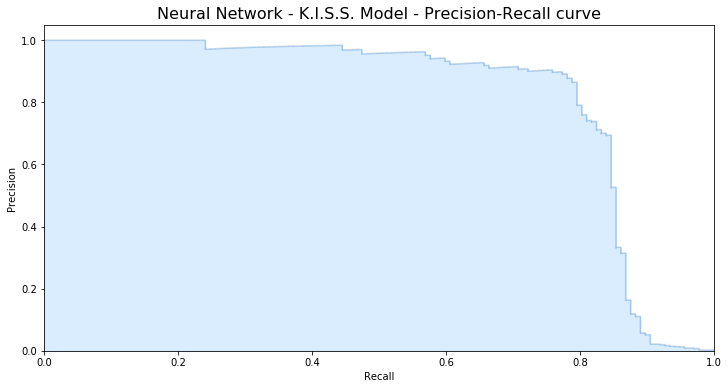

In [75]:
score_model(test_y, ks_preds, ks_model, "Neural Network - K.I.S.S.")

In [76]:
ks_model.save("capstone_models/imbalanced/nn_model_kiss.h5")
print("Saved model to disk")

# load model
ks_model = load_model('capstone_models/imbalanced/nn_model_kiss.h5')

Saved model to disk


In [77]:
# ks_model

#### Deeper Neural Network

In [78]:
nn_fitted = nn_model.fit(train_x, 
                         train_y, 
                         validation_split=0.2, 
                         batch_size=25,
                         epochs=20,
                         shuffle=True,
                         verbose=2)

Train on 159491 samples, validate on 39873 samples
Epoch 1/20
159491/159491 - 9s - loss: 0.0392 - binary_accuracy: 0.9654 - val_loss: 0.0048 - val_binary_accuracy: 0.9649
Epoch 2/20
159491/159491 - 8s - loss: 0.0038 - binary_accuracy: 0.9650 - val_loss: 0.0045 - val_binary_accuracy: 0.9649
Epoch 3/20
159491/159491 - 8s - loss: 0.0034 - binary_accuracy: 0.9650 - val_loss: 0.0046 - val_binary_accuracy: 0.9649
Epoch 4/20
159491/159491 - 9s - loss: 0.0032 - binary_accuracy: 0.9650 - val_loss: 0.0040 - val_binary_accuracy: 0.9649
Epoch 5/20
159491/159491 - 9s - loss: 0.0031 - binary_accuracy: 0.9650 - val_loss: 0.0039 - val_binary_accuracy: 0.9649
Epoch 6/20
159491/159491 - 9s - loss: 0.0029 - binary_accuracy: 0.9650 - val_loss: 0.0038 - val_binary_accuracy: 0.9649
Epoch 7/20
159491/159491 - 8s - loss: 0.0029 - binary_accuracy: 0.9650 - val_loss: 0.0040 - val_binary_accuracy: 0.9649
Epoch 8/20
159491/159491 - 8s - loss: 0.0028 - binary_accuracy: 0.9650 - val_loss: 0.0043 - val_binary_accura

In [79]:
nn_preds = nn_model.predict_classes(test_x)

Scoring Results for: Neural Network - Inception
------------------------------
Precision: 0.84
Recall: 0.803
F1 Score: 0.821
Confusion Matrix: 
[[85285    21]
 [   27   110]]
AUPRC Score: 0.675


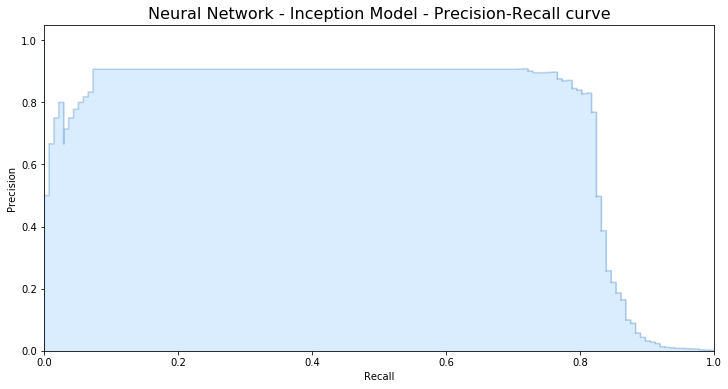

In [80]:
score_model(test_y, nn_preds, nn_model , 'Neural Network - Inception')

In [81]:
nn_model.save("capstone_models/imbalanced/nn_model_inception.h5")
print("Saved model to disk")

# load model
nn_model = load_model("capstone_models/imbalanced/nn_model_inception.h5")

Saved model to disk


In [82]:
nn_model

### Undersampling the dataset

In [84]:
#Initializing the Nearmiss Classifier
nearmiss = NearMiss(random_state=68)
# Undersampling the data
train_x_under, train_y_under = nearmiss.fit_sample(train_x, train_y)
print("Percentage of Fraud in Undersampled Data: {0}% ({1} total)".format((sum(train_y_under)*100/len(train_y_under)), len(train_y_under)))

Percentage of Fraud in Undersampled Data: 50.0% (710 total)


I am unclear on how to set certain parameters while also allowing other parameters to be probed by Bayesian optimzation. Because of this, I am going to have to redefine the functions with the undersampled data and the oversampled data. This will ideally be fixed with piping or altering the input for bayesian optimization. Since we are not using Bayesian Optimization for the neural networks, they do not have to be redefined 

#### SGDClassifier 

In [85]:
def SD_under_func(alpha, l1_ratio, max_iter, cv=5, n_jobs=-1, train_x = train_x_under, train_y = train_y_under):
    val = cross_val_score(SGDClassifier(alpha=alpha, 
                                     l1_ratio=l1_ratio, 
                                     max_iter = max_iter,
                                     random_state = 68),
                          train_x, 
                          train_y, 
                          cv=cv, 
                          n_jobs=n_jobs).mean()
    return val

In [86]:
sdg_under_BO = BayesianOptimization(SD_under_func, {"alpha":(1e-4,10), "l1_ratio":(0,1), "max_iter":(50,2000)})
sdg_under_BO.maximize(n_iter=30)    

|   iter    |  target   |   alpha   | l1_ratio  | max_iter  |
-------------------------------------------------------------
|  1        |  0.931    |  0.9028   |  0.44     |  1.343e+0 |
|  2        |  0.9324   |  0.6926   |  0.8605   |  1.912e+0 |
|  3        |  0.9282   |  1.53     |  0.6435   |  1.269e+0 |
|  4        |  0.931    |  0.8901   |  0.4529   |  1.824e+0 |
|  5        |  0.8958   |  7.579    |  0.1861   |  287.8    |
|  6        |  0.7535   |  9.991    |  0.1359   |  1.7e+03  |
|  7        |  0.9394   |  0.0001   |  0.0      |  714.2    |
|  8        |  0.9394   |  0.0001   |  1.0      |  50.0     |
|  9        |  0.9394   |  0.0001   |  0.0      |  950.2    |
|  10       |  0.9394   |  0.0001   |  1.0      |  504.7    |
|  11       |  0.7507   |  10.0     |  1.0      |  1.084e+0 |
|  12       |  0.7507   |  10.0     |  1.0      |  838.9    |
|  13       |  0.7507   |  10.0     |  0.0      |  2e+03    |
|  14       |  0.9394   |  0.0001   |  0.0      |  159.0    |
|  15   

In [87]:
max_score = 0
sd_best_params = {"alpha":0, "l1_ratio":0, "max_iter":0}
for i, res in enumerate(sdg_under_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        sd_best_params['alpha'] = res['params']['alpha']
        sd_best_params['l1_ratio'] = res['params']['l1_ratio']
        sd_best_params['max_iter'] = res['params']['max_iter']
print(max_score)
print(sd_best_params)

0.9394366197183098
{'alpha': 0.0001, 'l1_ratio': 0.0, 'max_iter': 714.2205764666114}


In [88]:
sd_model = SGDClassifier(alpha=sd_best_params['alpha'],
                      l1_ratio=sd_best_params['l1_ratio'], 
                      max_iter=sd_best_params['max_iter'],
                      random_state = 68)

In [89]:
sd_pipeline = make_pipeline(sd_model)
sd_fitted = sd_pipeline.fit(train_x_under, train_y_under)
sd_preds = sd_fitted.predict(test_x)

Scoring Results for: SDG Classifier - Undersample
------------------------------
Precision: 0.003
Recall: 0.956
F1 Score: 0.006
Confusion Matrix: 
[[38574 46732]
 [    6   131]]
AUPRC Score: 0.003


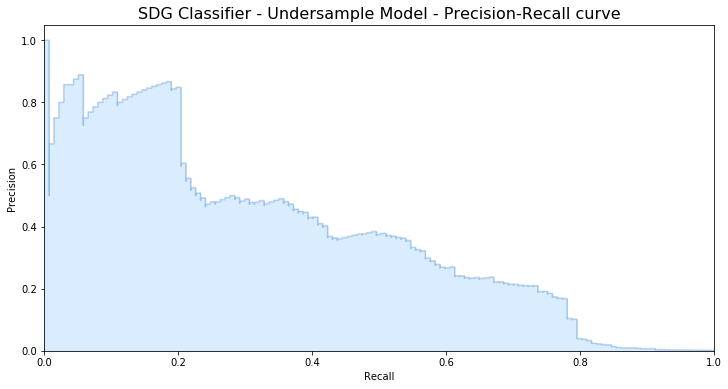

In [90]:
score_model(test_y, sd_preds, sd_fitted, 'SDG Classifier - Undersample')

In [91]:
joblib.dump(sd_fitted, 'capstone_models/undersampled/sdgclassifier.pkl') 
joblib.load('capstone_models/undersampled/sdgclassifier.pkl')  


Pipeline(memory=None,
         steps=[('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.0,
                               learning_rate='optimal', loss='hinge',
                               max_iter=714.2205764666114, n_iter_no_change=5,
                               n_jobs=None, penalty='l2', power_t=0.5,
                               random_state=68, shuffle=True, tol=0.001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False))],
         verbose=False)

Not a promising start...

#### Random Forest

In [92]:
def RF_under_func(n_estimators, max_depth, min_samples_split, cv=5, n_jobs=-1, train_x = train_x_under, train_y = train_y_under):
    val = cross_val_score(RandomForestClassifier(n_estimators = int(n_estimators),
                                               max_depth = int(max_depth),
                                               min_samples_split = int(min_samples_split),
                                               random_state = 68),
                         train_x, 
                         train_y, 
                         cv=5, 
                         n_jobs=n_jobs).mean()
    return val

In [93]:
rforest_under_BO = BayesianOptimization(RF_under_func, 
                                  {'n_estimators':(200,400), 
                                   'max_depth':(10,500),
                                   'min_samples_split':(2,10)})

rforest_under_BO.maximize(n_iter=30)  

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.9676   |  468.6    |  6.42     |  210.8    |
|  2        |  0.9676   |  265.2    |  8.008    |  297.5    |
|  3        |  0.9662   |  410.2    |  5.044    |  200.3    |
|  4        |  0.9676   |  207.2    |  6.096    |  352.7    |
|  5        |  0.9676   |  149.6    |  6.025    |  271.5    |
|  6        |  0.9704   |  496.5    |  5.092    |  400.0    |
|  7        |  0.969    |  498.6    |  4.772    |  399.8    |
|  8        |  0.9676   |  499.2    |  9.046    |  399.1    |
|  9        |  0.969    |  12.19    |  3.29     |  399.5    |
|  10       |  0.969    |  14.29    |  3.021    |  399.9    |
|  11       |  0.969    |  496.0    |  8.062    |  399.7    |
|  12       |  0.9676   |  12.39    |  9.47     |  399.9    |
|  13       |  0.969    |  496.1    |  2.124    |  399.9    |
|  14       |  0.969    |  499.5    |  8.332    |  399.9    |
|  15   

In [94]:
max_score = 0
rf_best_params = {"n_estimators":0, "max_depth":0, "min_samples_split":0}
for i, res in enumerate(rforest_under_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        rf_best_params['n_estimators'] = res['params']['n_estimators']
        rf_best_params['max_depth'] = res['params']['max_depth']
        rf_best_params['min_samples_split'] = res['params']['min_samples_split']
print(max_score)
print(rf_best_params)

0.9704225352112676
{'n_estimators': 399.9582628430328, 'max_depth': 496.5464018345728, 'min_samples_split': 5.09152229070322}


In [95]:
rf_model = RandomForestClassifier(n_estimators = int(rf_best_params['n_estimators']),
                                  max_depth = int(rf_best_params['max_depth']),
                                  min_samples_split = int(rf_best_params['min_samples_split']),
                                  random_state = 68)

In [96]:
rf_pipeline = make_pipeline(rf_model)
rf_fitted = rf_pipeline.fit(train_x_under, train_y_under)
rf_preds = rf_fitted.predict(test_x)

Scoring Results for: Random Forest - Undersample
------------------------------
Precision: 0.002
Recall: 0.964
F1 Score: 0.004
Confusion Matrix: 
[[10646 74660]
 [    5   132]]
AUPRC Score: 0.002


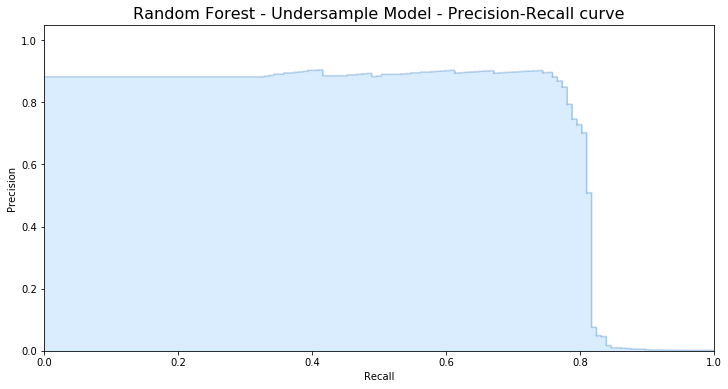

In [97]:
score_model(test_y, rf_preds, rf_fitted, 'Random Forest - Undersample')

In [98]:
joblib.dump(rf_fitted, "capstone_models/undersampled/randomforest.pkl") 
joblib.load("capstone_models/undersampled/randomforest.pkl")

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=496,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=399, n_jobs=None,
                                        oob_score=False, random_state=68,
                                        verbose=0, warm_start=False))],
         verbose=False)

I think that by undersampling the data, we lose too much information and cannot make good predictions. I doubt the rest of the models will be much different, but might as well try

#### XGBoost

In [101]:
def XG_under_func(n_estimators, learning_rate, max_depth, min_child_weight, gamma, colsample_bytree, cv = 5, train_x = train_x_under, train_y = train_y_under):
    val = cross_val_score(XGBClassifier(n_estimators=int(n_estimators),
                                        learning_rate = learning_rate,
                                        max_depth=int(max_depth), 
                                        min_child_weight = int(min_child_weight),
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree
                                        ),
                          train_x, 
                          train_y, 
                          cv = 5, 
                          n_jobs = -1).mean()
    return val

In [102]:
xgboost_under_BO = BayesianOptimization(XG_under_func, 
                                 {'n_estimators': (100, 1000),
                                     'learning_rate': (.001, .5),
                                     'max_depth': (1,20),
                                     "gamma": (0,1),
                                     'min_child_weight': (1,10),
                                     "colsample_bytree" : (0.1, 0.9)
                                 })

xgboost_under_BO.maximize(n_iter=30)  

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
|  1        |  0.9535   |  0.8717   |  0.6552   |  0.3416   |  12.77    |  8.25     |  649.7    |
|  2        |  0.9493   |  0.2866   |  0.0215   |  0.3955   |  8.053    |  6.922    |  352.5    |
|  3        |  0.9521   |  0.4044   |  0.9386   |  0.3534   |  18.55    |  7.971    |  761.2    |
|  4        |  0.9606   |  0.7584   |  0.02372  |  0.4915   |  8.203    |  1.636    |  919.6    |
|  5        |  0.9535   |  0.713    |  0.7906   |  0.3181   |  16.48    |  7.81     |  244.2    |
|  6        |  0.9577   |  0.3626   |  0.06073  |  0.3179   |  1.379    |  2.12     |  100.7    |
|  7        |  0.9437   |  0.5909   |  0.1083   |  0.2593   |  1.031    |  9.191    |  999.3    |
|  8        |  0.9549   |  0.9      |  0.0      |  0.001    |  20.0     |  1.0      |  101.0    |
|  9        |  0.959

In [103]:
max_score = 0
xg_best_params = {"n_estimators":0, 
                  "learning_rate":0, 
                  "max_depth":0,
                  "min_child_weight":0,
                  "gamma":0,
                  "colsample_bytree":0,
                 }
for i, res in enumerate(xgboost_under_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        xg_best_params['n_estimators'] = res['params']['n_estimators']
        xg_best_params['learning_rate'] = res['params']['learning_rate']
        xg_best_params['max_depth'] = res['params']['max_depth']
        xg_best_params['min_child_weight'] = res['params']['min_child_weight']
        xg_best_params['gamma'] = res['params']['gamma']
        xg_best_params['colsample_bytree'] = res['params']['colsample_bytree']
print(max_score)
print(xg_best_params)

0.9690140845070422
{'n_estimators': 923.487316586769, 'learning_rate': 0.4482812696494406, 'max_depth': 17.679625530724994, 'min_child_weight': 1.0456946456685765, 'gamma': 0.7067325590549964, 'colsample_bytree': 0.1034009143307042}


In [104]:
xg_model = XGBClassifier(n_estimators=int(xg_best_params['n_estimators']),
                         learning_rate = xg_best_params['learning_rate'],
                         max_depth=int(xg_best_params['max_depth']), 
                         min_child_weight = int(xg_best_params['min_child_weight']),
                         gamma = xg_best_params['gamma'],
                         colsample_bytree = xg_best_params['colsample_bytree']
                        )

In [105]:
xg_pipeline = make_pipeline(xg_model)
xg_fitted = xg_pipeline.fit(train_x_under, train_y_under)
xg_preds = xg_fitted.predict(test_x.values)

Scoring Results for: XGBoost - Undersample
------------------------------
Precision: 0.002
Recall: 0.971
F1 Score: 0.004
Confusion Matrix: 
[[13344 71962]
 [    4   133]]
AUPRC Score: 0.002


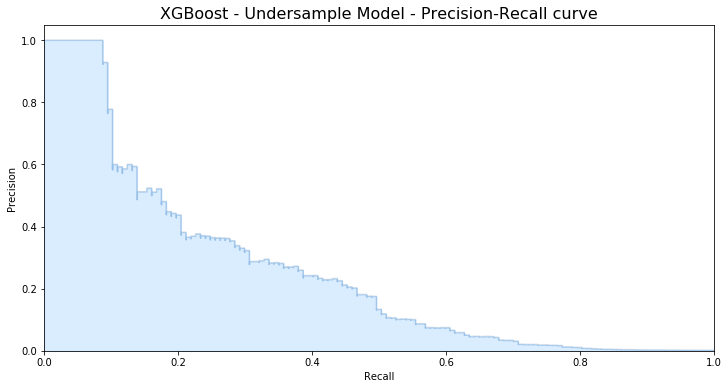

In [106]:
score_model(test_y.values, xg_preds, xg_fitted, 'XGBoost - Undersample')

In [107]:
joblib.dump(xg_fitted, "capstone_models/undersampled/xgboost.pkl") 
joblib.load("capstone_models/undersampled/xgboost.pkl")

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.1034009143307042,
                               gamma=0.7067325590549964,
                               learning_rate=0.4482812696494406,
                               max_delta_step=0, max_depth=17,
                               min_child_weight=1, missing=nan,
                               n_estimators=923, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

Although our more traditional models were failures, maybe our neural networks will have a better chance at predicting on such a small dataset

#### Simple Neural Network - K.I.S.S.

In [108]:
ks_fitted = ks_model.fit(train_x_under, train_y_under, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)


Train on 568 samples, validate on 142 samples
Epoch 1/20
568/568 - 0s - loss: 0.2710 - binary_accuracy: 0.6167 - val_loss: 0.6937 - val_binary_accuracy: 0.0333
Epoch 2/20
568/568 - 0s - loss: 0.1442 - binary_accuracy: 0.6167 - val_loss: 0.4947 - val_binary_accuracy: 0.0333
Epoch 3/20
568/568 - 0s - loss: 0.0961 - binary_accuracy: 0.6167 - val_loss: 0.3973 - val_binary_accuracy: 0.0333
Epoch 4/20
568/568 - 0s - loss: 0.0865 - binary_accuracy: 0.6167 - val_loss: 0.4226 - val_binary_accuracy: 0.0333
Epoch 5/20
568/568 - 0s - loss: 0.0806 - binary_accuracy: 0.6167 - val_loss: 0.4012 - val_binary_accuracy: 0.0333
Epoch 6/20
568/568 - 0s - loss: 0.0723 - binary_accuracy: 0.6167 - val_loss: 0.4185 - val_binary_accuracy: 0.0333
Epoch 7/20
568/568 - 0s - loss: 0.0704 - binary_accuracy: 0.6167 - val_loss: 0.4174 - val_binary_accuracy: 0.0333
Epoch 8/20
568/568 - 0s - loss: 0.0672 - binary_accuracy: 0.6167 - val_loss: 0.4143 - val_binary_accuracy: 0.0333
Epoch 9/20
568/568 - 0s - loss: 0.0666 - b

In [109]:
ks_preds = ks_model.predict_classes(test_x)

Scoring Results for: Neural Network - K.I.S.S. - Undersample
------------------------------
Precision: 0.147
Recall: 0.861
F1 Score: 0.251
Confusion Matrix: 
[[84620   686]
 [   19   118]]
AUPRC Score: 0.127


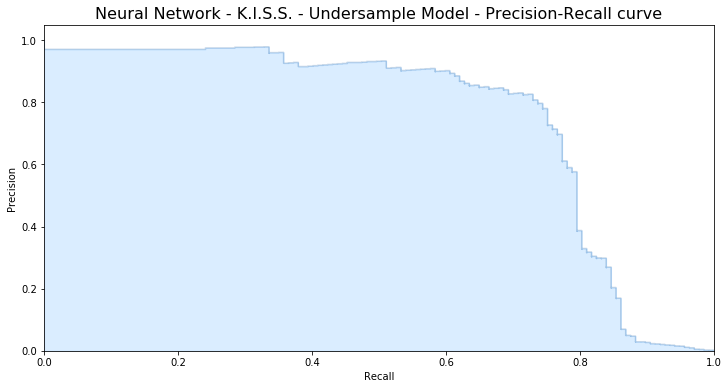

In [111]:
score_model(test_y, ks_preds, ks_model, "Neural Network - K.I.S.S. - Undersample")

In [112]:
ks_model.save("capstone_models/undersampled/nn_model_kiss.h5")
print("Saved model to disk")

# load model
ks_model = load_model('capstone_models/undersampled/nn_model_kiss.h5')

Saved model to disk


Very impressive, especially since it is able to predict on a large dataset only given ~700 observations. This is worlds better than the other undersampled models. That said, in comparison to our benchmark, it is similar in quality, which isn't a great thing.

#### Deeper Neural Network

In [113]:
nn_fitted = nn_model.fit(train_x_under, 
                         train_y_under, 
                         validation_split=0.2,
                         batch_size=25, 
                         epochs=20, 
                         shuffle=True, 
                         verbose=2)

Train on 568 samples, validate on 142 samples
Epoch 1/20
568/568 - 0s - loss: 0.2309 - binary_accuracy: 0.6167 - val_loss: 0.2806 - val_binary_accuracy: 0.0333
Epoch 2/20
568/568 - 0s - loss: 0.1803 - binary_accuracy: 0.6167 - val_loss: 0.3649 - val_binary_accuracy: 0.0333
Epoch 3/20
568/568 - 0s - loss: 0.1466 - binary_accuracy: 0.6167 - val_loss: 0.3797 - val_binary_accuracy: 0.0333
Epoch 4/20
568/568 - 0s - loss: 0.1196 - binary_accuracy: 0.6167 - val_loss: 0.3033 - val_binary_accuracy: 0.0333
Epoch 5/20
568/568 - 0s - loss: 0.1321 - binary_accuracy: 0.6167 - val_loss: 0.3380 - val_binary_accuracy: 0.0333
Epoch 6/20
568/568 - 0s - loss: 0.1025 - binary_accuracy: 0.6167 - val_loss: 0.3244 - val_binary_accuracy: 0.0333
Epoch 7/20
568/568 - 0s - loss: 0.1013 - binary_accuracy: 0.6167 - val_loss: 0.3290 - val_binary_accuracy: 0.0333
Epoch 8/20
568/568 - 0s - loss: 0.1127 - binary_accuracy: 0.6167 - val_loss: 0.3266 - val_binary_accuracy: 0.0333
Epoch 9/20
568/568 - 0s - loss: 0.0962 - b

In [114]:
nn_preds = nn_model.predict_classes(test_x)

Scoring Results for: Neural Network - Inception - Undersampled
------------------------------
Precision: 0.218
Recall: 0.847
F1 Score: 0.347
Confusion Matrix: 
[[84890   416]
 [   21   116]]
AUPRC Score: 0.185


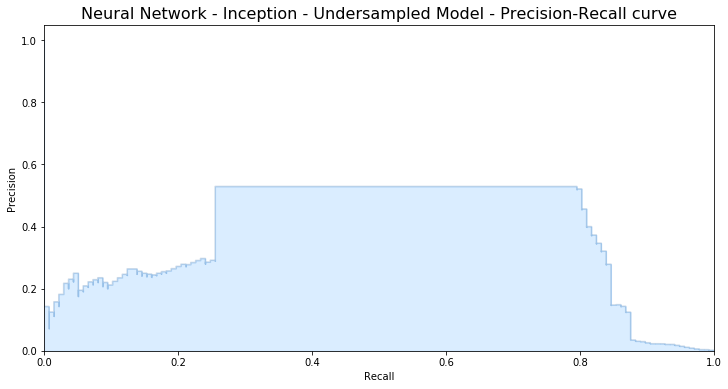

In [115]:
score_model(test_y, nn_preds, nn_model, "Neural Network - Inception - Undersampled")

In [116]:
nn_model.save("capstone_models/undersampled/nn_model_inception.h5")
print("Saved model to disk")

# load model
nn_model = load_model('capstone_models/undersampled/nn_model_inception.h5')

Saved model to disk


### Oversampling the dataset

Since undersampling the dataset was rather disasterous for the model quality, lets try oversampling the data. We will use SMOTE, which similuates similar minority cases until the total number of fraudulent and non-fraudulent cases are around 50/50

In [118]:
#Initializing the SMOTE Classifier
smote = SMOTE(random_state=68)
# Oversample the data
train_x_over, train_y_over = smote.fit_sample(train_x, train_y)
print("Percentage of Fraud in Undersampled Data: {0}% ({1} total)".format((sum(train_y_under)*100/len(train_y_under)), len(train_y_under)))

Percentage of Fraud in Undersampled Data: 50.0% (710 total)


#### SGDClassifier 

In [119]:
def SD_over_func(alpha, l1_ratio, max_iter, cv=5, n_jobs=-1, train_x = train_x_over, train_y = train_y_over):
    val = cross_val_score(SGDClassifier(alpha=alpha, 
                                     l1_ratio=l1_ratio, 
                                     max_iter = max_iter,
                                     random_state = 68),
                          train_x, 
                          train_y, 
                          cv=cv, 
                          n_jobs=n_jobs).mean()
    return val

In [120]:
sdg_over_BO = BayesianOptimization(SD_over_func, {"alpha":(1e-4,10), "l1_ratio":(0,1), "max_iter":(25,2000)})
sdg_over_BO.maximize(n_iter=30)    

|   iter    |  target   |   alpha   | l1_ratio  | max_iter  |
-------------------------------------------------------------
|  1        |  0.9161   |  3.138    |  0.6774   |  573.8    |
|  2        |  0.9307   |  5.912    |  0.1959   |  1.7e+03  |
|  3        |  0.9164   |  3.314    |  0.7195   |  193.5    |
|  4        |  0.9167   |  2.257    |  0.5712   |  1.423e+0 |
|  5        |  0.9288   |  0.5095   |  0.1079   |  1.868e+0 |
|  6        |  0.8285   |  9.89     |  0.7392   |  1.998e+0 |
|  7        |  0.9527   |  0.0001   |  0.0      |  980.0    |
|  8        |  0.9527   |  0.0001   |  0.0      |  25.0     |
|  9        |  0.9455   |  0.03535  |  0.2451   |  1.164e+0 |
|  10       |  0.8157   |  9.99     |  0.4171   |  805.4    |
|  11       |  0.9527   |  0.0001   |  0.0      |  399.2    |
|  12       |  0.8156   |  9.99     |  0.6771   |  1.062e+0 |
|  13       |  0.9527   |  0.0001   |  0.0      |  1.292e+0 |
|  14       |  0.9527   |  0.0001   |  0.0      |  1.567e+0 |
|  15   

In [121]:
max_score = 0
sd_best_params = {"alpha":0, "l1_ratio":0, "max_iter":0}
for i, res in enumerate(sdg_over_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        sd_best_params['alpha'] = res['params']['alpha']
        sd_best_params['l1_ratio'] = res['params']['l1_ratio']
        sd_best_params['max_iter'] = res['params']['max_iter']
print(max_score)
print(sd_best_params)

0.9527383267709822
{'alpha': 0.0001, 'l1_ratio': 0.0, 'max_iter': 979.9644952896513}


In [122]:
sd_model = SGDClassifier(alpha=sd_best_params['alpha'],
                      l1_ratio=sd_best_params['l1_ratio'], 
                      max_iter=sd_best_params['max_iter'],
                      random_state = 68)

In [123]:
sd_pipeline = make_pipeline(sd_model)
sd_fitted = sd_pipeline.fit(train_x_over, train_y_over)
sd_preds = sd_fitted.predict(test_x)

Scoring Results for: SDG Classifier - Oversampled
------------------------------
Precision: 0.051
Recall: 0.883
F1 Score: 0.097
Confusion Matrix: 
[[83058  2248]
 [   16   121]]
AUPRC Score: 0.045


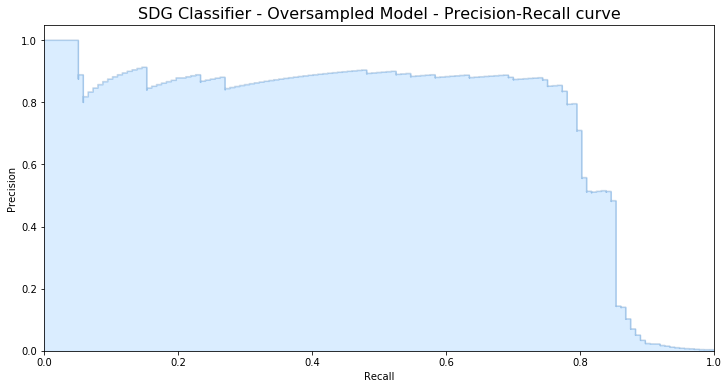

In [124]:
score_model(test_y, sd_preds, sd_fitted, 'SDG Classifier - Oversampled')

In [125]:
joblib.dump(sd_fitted, 'capstone_models/oversampled/sdgclassifier.pkl') 
sd_fitted = joblib.load('capstone_models/oversampled/sdgclassifier.pkl')  
sd_fitted

Pipeline(memory=None,
         steps=[('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.0,
                               learning_rate='optimal', loss='hinge',
                               max_iter=979.9644952896513, n_iter_no_change=5,
                               n_jobs=None, penalty='l2', power_t=0.5,
                               random_state=68, shuffle=True, tol=0.001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False))],
         verbose=False)

#### Random Forest

In [127]:
def RF_over_func(n_estimators, max_depth, min_samples_split, cv=5, n_jobs=-1, train_x = train_x_over, train_y = train_y_over):
    val = cross_val_score(RandomForestClassifier(n_estimators = int(n_estimators),
                                               max_depth = int(max_depth),
                                               min_samples_split = int(min_samples_split),
                                               random_state = 68),
                         train_x, 
                         train_y, 
                         cv=5, 
                         n_jobs=n_jobs).mean()
    return val

I have previously trained the model before but restarted the notebook. Before restarting the notebook I made sure to save the models, located below

In [163]:
rf_fitted = joblib.load('capstone_models/oversampled/randomforest.pkl')  

The cells below are how I got to this model, but will not rerun them since they take ~6 hours to train

In [159]:
rforest_over_BO = BayesianOptimization(RF_over_func, 
                                  {'n_estimators':(200,400), 
                                   'max_depth':(10,500),
                                   'min_samples_split':(2,10)})

rforest_over_BO.maximize(n_iter=30)  

In [160]:
max_score = 0
rf_best_params = {"n_estimators":0, "max_depth":0, "min_samples_split":0}
for i, res in enumerate(rforest_over_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        rf_best_params['n_estimators'] = res['params']['n_estimators']
        rf_best_params['max_depth'] = res['params']['max_depth']
        rf_best_params['min_samples_split'] = res['params']['min_samples_split']
print(max_score)
print(rf_best_params)

In [162]:
rf_model = RandomForestClassifier(n_estimators = int(rf_best_params['n_estimators']),
                                  max_depth = int(rf_best_params['max_depth']),
                                  min_samples_split = int(rf_best_params['min_samples_split']),
                                  random_state = 68)

In [141]:
# rf_pipeline = make_pipeline(rf_model)
rf_fitted = rf_pipeline.fit(train_x_over, train_y_over)
rf_preds = rf_fitted.predict(test_x)

Scoring Results for: Random Forest - Oversampled
------------------------------
Precision: 0.889
Recall: 0.818
F1 Score: 0.852
Confusion Matrix: 
[[85292    14]
 [   25   112]]
AUPRC Score: 0.727


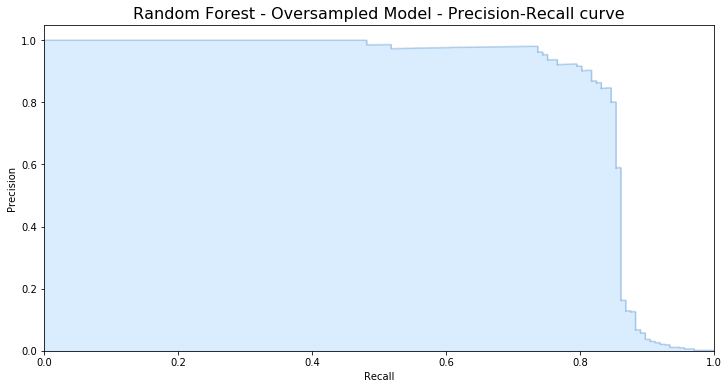

In [142]:
score_model(test_y, rf_preds, rf_fitted, 'Random Forest - Oversampled')

In [140]:
joblib.dump(rf_fitted, 'capstone_models/oversampled/randomforest.pkl') 
rf_fitted = joblib.load('capstone_models/oversampled/randomforest.pkl')  


#### XGBoost

In [149]:
def XG_over_func(n_estimators, learning_rate, max_depth, min_child_weight, gamma, colsample_bytree, cv = 5, train_x = train_x_over, train_y = train_y_over):
    val = cross_val_score(XGBClassifier(n_estimators=int(n_estimators),
                                        learning_rate = learning_rate,
                                        max_depth=int(max_depth), 
                                        min_child_weight = int(min_child_weight),
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree
                                        ),
                          train_x, 
                          train_y, 
                          cv = 5, 
                          n_jobs = -1).mean()
    return val

I have previously trained the model before but restarted the notebook. Before restarting the notebook I made sure to save the models, located below

In [164]:
xg_fitted = joblib.load("capstone_models/oversampled/xgboost.pkl")

The cells below are how I got to this model, but will not rerun them since they take ~4 hours to train

In [161]:
xgboost_over_BO = BayesianOptimization(XG_over_func, 
                                 {'n_estimators': (100, 1000),
                                     'learning_rate': (.001, .5),
                                     'max_depth': (1,20),
                                     "gamma": (0,1),
                                     'min_child_weight': (1,10),
                                     "colsample_bytree" : (0.1, 0.9)
                                 })

xgboost_over_BO.maximize(n_iter=30)  

In [155]:
max_score = 0
xg_best_params = {"n_estimators":0, 
                  "learning_rate":0, 
                  "max_depth":0,
                  "min_child_weight":0,
                  "gamma":0,
                  "colsample_bytree":0,
                 }
for i, res in enumerate(xgboost_over_BO.res):
    if res['target'] > max_score:
        max_score = res['target']
        xg_best_params['n_estimators'] = res['params']['n_estimators']
        xg_best_params['learning_rate'] = res['params']['learning_rate']
        xg_best_params['max_depth'] = res['params']['max_depth']
        xg_best_params['min_child_weight'] = res['params']['min_child_weight']
        xg_best_params['gamma'] = res['params']['gamma']
        xg_best_params['colsample_bytree'] = res['params']['colsample_bytree']
print(max_score)
print(xg_best_params)

In [156]:
xg_model = XGBClassifier(n_estimators=int(xg_best_params['n_estimators']),
                         learning_rate = xg_best_params['learning_rate'],
                         max_depth=int(xg_best_params['max_depth']), 
                         min_child_weight = int(xg_best_params['min_child_weight']),
                         gamma = xg_best_params['gamma'],
                         colsample_bytree = xg_best_params['colsample_bytree']
                        )

In [157]:
xg_pipeline = make_pipeline(xg_model)
xg_fitted = xg_pipeline.fit(train_x_over, train_y_over)
xg_preds = xg_fitted.predict(test_x.values)

Scoring Results for: XGBoost - Oversampled
------------------------------
Precision: 0.828
Recall: 0.81
F1 Score: 0.819
Confusion Matrix: 
[[85283    23]
 [   26   111]]
AUPRC Score: 0.671


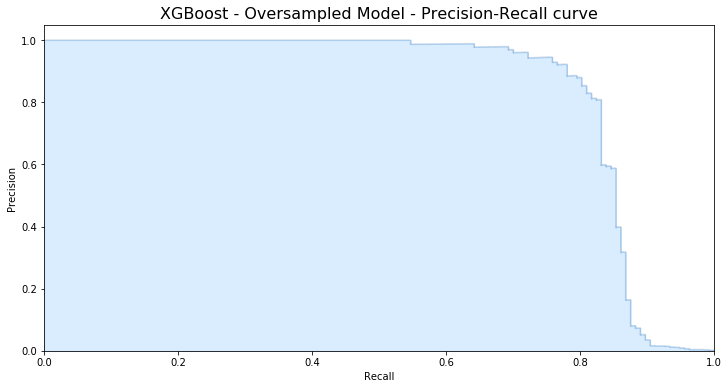

In [158]:
score_model(test_y, xg_preds, xg_fitted, 'XGBoost - Oversampled')

In [151]:
joblib.dump(xg_fitted, "capstone_models/oversampled/xgboost.pkl") 
xg_fitted = joblib.load("capstone_models/oversampled/xgboost.pkl")

#### Simple Neural Network - K.I.S.S.

In [129]:
ks_fitted = ks_model.fit(train_x_over, train_y_over, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)


Train on 318414 samples, validate on 79604 samples
Epoch 1/20
318414/318414 - 17s - loss: 0.0111 - binary_accuracy: 0.6167 - val_loss: 0.0078 - val_binary_accuracy: 0.0333
Epoch 2/20
318414/318414 - 16s - loss: 0.0044 - binary_accuracy: 0.6167 - val_loss: 0.0082 - val_binary_accuracy: 0.0333
Epoch 3/20
318414/318414 - 17s - loss: 0.0030 - binary_accuracy: 0.6167 - val_loss: 0.0050 - val_binary_accuracy: 0.0333
Epoch 4/20
318414/318414 - 18s - loss: 0.0022 - binary_accuracy: 0.6167 - val_loss: 0.0096 - val_binary_accuracy: 0.0333
Epoch 5/20
318414/318414 - 16s - loss: 0.0019 - binary_accuracy: 0.6167 - val_loss: 8.5370e-04 - val_binary_accuracy: 0.0333
Epoch 6/20
318414/318414 - 16s - loss: 0.0017 - binary_accuracy: 0.6167 - val_loss: 0.0017 - val_binary_accuracy: 0.0333
Epoch 7/20
318414/318414 - 17s - loss: 0.0016 - binary_accuracy: 0.6167 - val_loss: 3.7057e-04 - val_binary_accuracy: 0.0333
Epoch 8/20
318414/318414 - 17s - loss: 0.0014 - binary_accuracy: 0.6167 - val_loss: 0.0015 - v

In [130]:
ks_preds = ks_model.predict_classes(test_x)

Scoring Results for: Neural Network - K.I.S.S. - Oversampled
------------------------------
Precision: 0.74
Recall: 0.788
F1 Score: 0.763
Confusion Matrix: 
[[85268    38]
 [   29   108]]
AUPRC Score: 0.583


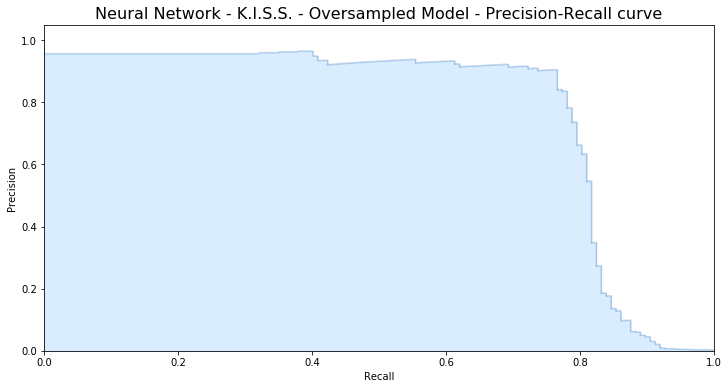

In [132]:
score_model(test_y, ks_preds, ks_model, "Neural Network - K.I.S.S. - Oversampled")

In [133]:
ks_model.save("capstone_models/oversampled/nn_model_kiss.h5")
print("Saved model to disk")

# load model
ks_model = load_model('capstone_models/oversampled/nn_model_kiss.h5')

Saved model to disk


#### Deeper Neural Network

In [135]:
nn_fitted = nn_model.fit(train_x_over, 
                         train_y_over, 
                         validation_split=0.2,
                         batch_size=25, 
                         epochs=20,
                         shuffle=True, 
                         verbose=2)

Train on 318414 samples, validate on 79604 samples
Epoch 1/20
318414/318414 - 19s - loss: 0.0145 - binary_accuracy: 0.6167 - val_loss: 0.0017 - val_binary_accuracy: 0.0333
Epoch 2/20
318414/318414 - 18s - loss: 0.0054 - binary_accuracy: 0.6167 - val_loss: 5.8439e-04 - val_binary_accuracy: 0.0333
Epoch 3/20
318414/318414 - 18s - loss: 0.0045 - binary_accuracy: 0.6167 - val_loss: 0.0015 - val_binary_accuracy: 0.0333
Epoch 4/20
318414/318414 - 18s - loss: 0.0038 - binary_accuracy: 0.6167 - val_loss: 0.0020 - val_binary_accuracy: 0.0333
Epoch 5/20
318414/318414 - 18s - loss: 0.0034 - binary_accuracy: 0.6167 - val_loss: 0.0011 - val_binary_accuracy: 0.0333
Epoch 6/20
318414/318414 - 18s - loss: 0.0033 - binary_accuracy: 0.6167 - val_loss: 9.1765e-04 - val_binary_accuracy: 0.0333
Epoch 7/20
318414/318414 - 18s - loss: 0.0030 - binary_accuracy: 0.6167 - val_loss: 0.0064 - val_binary_accuracy: 0.0333
Epoch 8/20
318414/318414 - 18s - loss: 0.0029 - binary_accuracy: 0.6167 - val_loss: 0.0045 - v

In [136]:
nn_preds = nn_model.predict_classes(test_x)

Scoring Results for: Neural Network - Inception - Oversampled
------------------------------
Precision: 0.732
Recall: 0.796
F1 Score: 0.762
Confusion Matrix: 
[[85266    40]
 [   28   109]]
AUPRC Score: 0.582


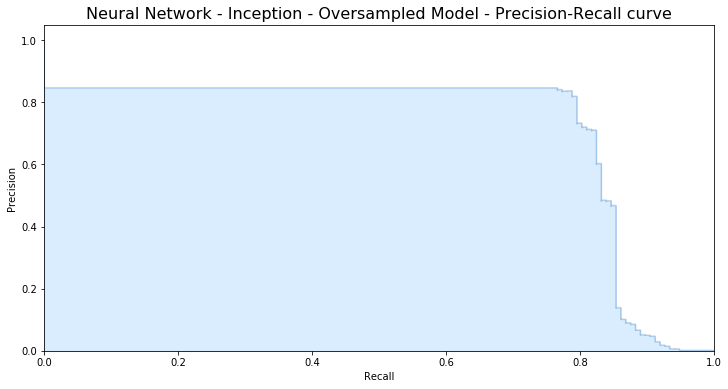

In [137]:
score_model(test_y, nn_preds, nn_model, 'Neural Network - Inception - Oversampled')

In [138]:
nn_model.save("capstone_models/oversampled/nn_model_inception.h5")
print("Saved model to disk")

# load model
nn_model = load_model('capstone_models/oversampled/nn_model_inception.h5')

Saved model to disk
